# AnnoTree-diamond-jupyter

This notebook is part of the analysis of the TotalRNA mRNA genes from Trinity.

##### What's Diamond
DIAMOND is a sequence aligner for protein and translated DNA searches designed for high-performance analysis of big sequence data. 

##### Why AnnoTree?
The NCBI-nr database is not explicitly designed for microbiome analysis, and its increasing size makes it unwieldy and computationally expensive for this purpose. The AnnoTree protein database is only one-quarter the size of the entire NCBI-nr database and is explicitly designed for metagenomic analysis, so alignment-based pipelines should support it.
https://journals.asm.org/doi/10.1128/msystems.01408-21

##### Which input files?

1. Trinity fasta file
2. Abundance-filtered coun table

##### Which preprocessing?

We use the naïve LCA (lowest common ancestor) approach for taxonomic annotation (Huson et al., 2007) and the best hit approach for functional assignment (Huson, Mitra, Weber, Ruscheweyh, & Schuster, 2011).

Then, this notebook is **heavily** inspired by Megan. 

##### Which database files?

We are using three different files (all of them in /Databases/AnnoTree_mRNA/)
'annotree.dmnd' is a diamond database (a particular format obtained from a fasta file)
'megan-mapping-annotree-June-2021.db' is an SQLite file with mappings from the name of each protein to annotations. 
'ko00001.json' is a JSON file with the BRITE hierarchy annotation  for KEGG

## Analysis
First, check dependencies. Safe to ignore.


In [1]:
%%bash
diamond --version
python -c "import pandas; print(pandas.__version__)"
python -c "import matplotlib; print(matplotlib.__version__)"
python -c "import ete3; print(ete3.__version__)"
bash --version | head -n 1

diamond version 2.0.11
2.1.1
3.8.0
3.1.3
GNU bash, version 4.4.20(1)-release (x86_64-pc-linux-gnu)


In [2]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import closing
from enum import Enum

### Input files (edit this chunk)
Edit this chunk to match your input files

In [3]:
trinity_file = snakemake.input.trinity
count_table = snakemake.input.count_table

In [4]:
## Sanity check: trinity and count table exit
assert os.path.exists(trinity_file), 'Trinity file does not exist'
assert os.path.exists(count_table), 'Count table does not exist'

### Output files (edit this chunk)
Edit this chunk to match your desired output files

In [5]:
outfile_matches = snakemake.output.diamond

### Database files
Don't edit this chunk

In [6]:
annotree_db = snakemake.input.database
mapping_db = snakemake.input.mapping
brite_json = snakemake.input.brite
threads = snakemake.threads
assert os.path.exists(f"{annotree_db}"), 'Annotree database does not exist'
assert os.path.exists(mapping_db), 'Mapping database does not exist'
assert os.path.exists(brite_json), 'Brite json file does not exist'
assert threads > 0, 'Threads must be greater than 0'

##### Run Diamond
When using Diamond, you should consider which sensitivity mode do you want to use. Default mode is designed for finding hits of >60% identity and it should take less than one hour to run. You might consider increase the sensitivity by editing the chunk below. 

In [7]:
%%bash -s "$annotree_db" "$trinity_file" "$outfile_matches" "$threads"
if [ ! -f $3 ]; then
mkdir -p $(dirname $3)
diamond blastx -p $4 -d $1 -q $2 -o $3 > /dev/null
fi
head $3


TRINITY_DN1457771_c0_g1_i1	NZ_CP011341_1_4810__RS_GCF_000982715_1	94.6	129	7	0	1	387	65	193	8.68e-71	232
TRINITY_DN1457771_c0_g1_i1	PKXE01000184_1_2__GB_GCA_003132265_1	88.4	129	15	0	1	387	64	192	1.65e-70	221
TRINITY_DN1457771_c0_g1_i1	PMOY01000055_1_1__GB_GCA_003165655_1	96.9	129	4	0	1	387	64	192	4.11e-70	236
TRINITY_DN1457771_c0_g1_i1	NZ_BCXE01000002_1_11__RS_GCF_001894945_1	94.6	129	7	0	1	387	65	193	1.90e-68	232
TRINITY_DN1457771_c0_g1_i1	PLIQ01000490_1_2__GB_GCA_003140115_1	94.6	129	7	0	1	387	65	193	2.37e-68	229
TRINITY_DN1457771_c0_g1_i1	PLWW01000083_1_79__GB_GCA_003153125_1	93.0	129	9	0	1	387	64	192	6.68e-68	230
TRINITY_DN1457771_c0_g1_i1	NZ_CSTD01000006_1_262__RS_GCF_001053185_1	92.2	129	10	0	1	387	65	193	1.26e-67	229
TRINITY_DN1457771_c0_g1_i1	PMST01000329_1_17__GB_GCA_003168295_1	94.6	129	7	0	1	387	65	193	2.43e-67	229
TRINITY_DN1457771_c0_g1_i1	NZ_FUEZ01000004_1_2847__RS_GCF_900157365_1	93.0	129	9	0	1	387	65	193	3.23e-67	228
TRINITY_DN1457771_c0_g1_i1	NZ_UPHQ01000169_1_6__RS_G

##### Preprocessing Diamond matches
We read the file into a pandas table:

In [8]:
diamond = pd.read_csv(
    outfile_matches,delimiter='\t',comment='#', header=None,
    names= ['Query_id', 'Subject_id', '%_identity', 'alignment_length', 
             'mismatches','gap_openings','q_start', 'q_end',
             's_start',
              's_end', 'e-value', 'score'
            ]
)
diamond

,Query_id,Subject_id,%_identity,alignment_length,mismatches,gap_openings,q_start,q_end,s_start,s_end,e-value,score
0,TRINITY_DN1457771_c0_g1_i1,NZ_CP011341_1_4810__RS_GCF_000982715_1,94.6,129,7,0,1,387,65,193,8.680000e-71,232.0
1,TRINITY_DN1457771_c0_g1_i1,PKXE01000184_1_2__GB_GCA_003132265_1,88.4,129,15,0,1,387,64,192,1.650000e-70,221.0
2,TRINITY_DN1457771_c0_g1_i1,PMOY01000055_1_1__GB_GCA_003165655_1,96.9,129,4,0,1,387,64,192,4.110000e-70,236.0
3,TRINITY_DN1457771_c0_g1_i1,NZ_BCXE01000002_1_11__RS_GCF_001894945_1,94.6,129,7,0,1,387,65,193,1.900000e-68,232.0
4,TRINITY_DN1457771_c0_g1_i1,PLIQ01000490_1_2__GB_GCA_003140115_1,94.6,129,7,0,1,387,65,193,2.370000e-68,229.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1760765,TRINITY_DN723407_c0_g1_i1,NZ_VCHP01000001_1_697__RS_GCF_005860925_1,30.7,228,142,6,913,251,66,284,9.680000e-23,105.0
1760766,TRINITY_DN723407_c0_g1_i1,NZ_JYKA01000028_1_26__RS_GCF_001676875_1,27.6,275,169,7,913,116,69,322,1.050000e-22,105.0
1760767,TRINITY_DN723407_c0_g1_i1,NZ_LODW01000104_1_290__RS_GCF_002914525_1,29.4,228,145,6,913,251,65,283,1.320000e-22,105.0
1760768,TRINITY_DN723407_c0_g1_i1,NZ_AEYF01000003_1_78__RS_GCF_000292525_1,30.7,228,142,6,913,251,66,284,1.340000e-22,105.0


We also add the count table into a Pandas data frame:

In [11]:
counts = pd.read_csv(
    count_table, sep = "\t", comment='#'
).set_index('ContigID')
counts

,t1,t10,t11,t12,t13,t14,t15,t16,t17,t18,...,t22,t23,t24,t3,t4,t5,t6,t7,t8,t9
ContigID,,,,,,,,,,,,,,,,,,,,,
TRINITY_DN0_c0_g1_i1,10,4,2,3,6,13,7,16,18,5,...,9,5,9,9,10,12,5,11,17,20
TRINITY_DN0_c0_g1_i11,88,38,46,23,97,121,81,136,75,81,...,124,93,71,61,69,110,82,108,90,215
TRINITY_DN0_c0_g1_i13,2,2,2,4,3,4,3,6,4,4,...,5,1,2,3,4,2,2,5,16,10
TRINITY_DN0_c0_g1_i2,9,4,0,1,3,2,4,4,5,0,...,2,2,5,3,7,5,1,3,17,6
TRINITY_DN0_c0_g1_i4,8,0,6,2,7,3,3,8,10,3,...,8,4,1,0,13,10,4,10,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRINITY_DN9_c0_g3_i1,2,2,7,3,8,4,4,8,2,1,...,3,4,0,5,3,3,3,14,4,1
TRINITY_DN9_c0_g3_i2,14,28,20,71,16,56,26,24,12,22,...,52,16,10,22,12,2,6,17,24,12
TRINITY_DN9_c0_g3_i3,72,8,205,45,14,24,18,40,10,13,...,36,32,20,43,49,17,23,58,18,154


# Preprocessing

The thresholds we are going to use should be adapted to the data. 

### Min-score
We are going to set a minimum threshol for the score to be **considered**. The read length is relevant for this choice. Please, be aware the next chunk of code *only* works for Trinity fasta files. If you are using another assembler, you should change the code accordingly.

In [12]:
%%bash -s "$trinity_file"
grep ">" $1 | awk '{print $2}' | sed 's/len=//g' > results/contig_lengths.txt

Mean: 768.3915657002365


<Axes: ylabel='Density'>

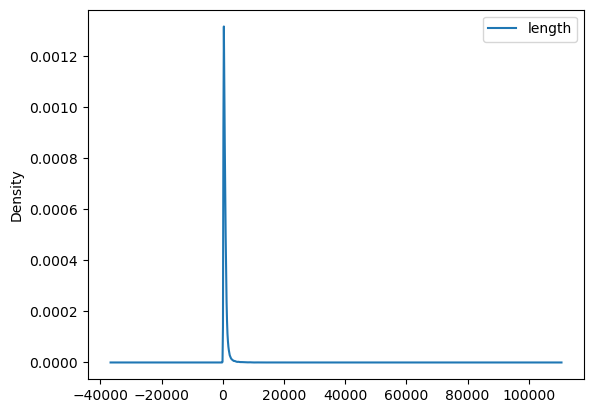

In [13]:
# read contig lengths and plot histogram
read_length = pd.read_csv(
    'results/contig_lengths.txt', header=None, names=['length']
)
print(f"Mean: {read_length['length'].mean()}")
read_length.plot(kind='density')

For sequences ∼100 bp, something like a min-score of 35 is reasonable. For longer sequences, ∼800 bp, a min-score of 100 is reasonable.

In [14]:
min_score_threshold = 100
diamond_filtered = diamond[diamond.score > min_score_threshold]
diamond_filtered

,Query_id,Subject_id,%_identity,alignment_length,mismatches,gap_openings,q_start,q_end,s_start,s_end,e-value,score
0,TRINITY_DN1457771_c0_g1_i1,NZ_CP011341_1_4810__RS_GCF_000982715_1,94.6,129,7,0,1,387,65,193,8.680000e-71,232.0
1,TRINITY_DN1457771_c0_g1_i1,PKXE01000184_1_2__GB_GCA_003132265_1,88.4,129,15,0,1,387,64,192,1.650000e-70,221.0
2,TRINITY_DN1457771_c0_g1_i1,PMOY01000055_1_1__GB_GCA_003165655_1,96.9,129,4,0,1,387,64,192,4.110000e-70,236.0
3,TRINITY_DN1457771_c0_g1_i1,NZ_BCXE01000002_1_11__RS_GCF_001894945_1,94.6,129,7,0,1,387,65,193,1.900000e-68,232.0
4,TRINITY_DN1457771_c0_g1_i1,PLIQ01000490_1_2__GB_GCA_003140115_1,94.6,129,7,0,1,387,65,193,2.370000e-68,229.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,TRINITY_DN130064_c4_g4_i1,NZ_SMLL01000010_1_46__RS_GCF_004681965_1,95.6,68,3,0,204,1,50,117,4.710000e-37,134.0
29996,TRINITY_DN130064_c4_g4_i1,PTEU01000002_1_622__GB_GCA_004359425_1,95.6,68,3,0,204,1,50,117,4.710000e-37,134.0
29997,TRINITY_DN130064_c4_g4_i1,SAIV01000082_1_50__GB_GCA_004028785_1,95.6,68,3,0,204,1,50,117,4.710000e-37,134.0
29998,TRINITY_DN130064_c4_g4_i1,SYDB01000053_1_8__GB_GCA_005786815_1,95.6,68,3,0,204,1,50,117,4.710000e-37,134.0


##  Top-percent filter
We are going to keep all hits that are within the top 10% of the best hit (a useful range is 10%-20%). The lowest, the more over-prediction. The highest, the more 'vague' the annotation. Imagine a very well-conserved protein, it's likely that if you include all the hits you will end with a 'vague' annotation such as *Bacteria*. 

In [15]:
threshold=0.95
diamond_filtered = diamond_filtered[diamond_filtered.groupby('Query_id')['score'].transform(lambda x: x >= threshold * x.max())].reset_index(drop=True)
diamond_filtered

,Query_id,Subject_id,%_identity,alignment_length,mismatches,gap_openings,q_start,q_end,s_start,s_end,e-value,score
0,TRINITY_DN1457771_c0_g1_i1,NZ_CP011341_1_4810__RS_GCF_000982715_1,94.6,129,7,0,1,387,65,193,8.680000e-71,232.0
1,TRINITY_DN1457771_c0_g1_i1,PMOY01000055_1_1__GB_GCA_003165655_1,96.9,129,4,0,1,387,64,192,4.110000e-70,236.0
2,TRINITY_DN1457771_c0_g1_i1,NZ_BCXE01000002_1_11__RS_GCF_001894945_1,94.6,129,7,0,1,387,65,193,1.900000e-68,232.0
3,TRINITY_DN1457771_c0_g1_i1,PLIQ01000490_1_2__GB_GCA_003140115_1,94.6,129,7,0,1,387,65,193,2.370000e-68,229.0
4,TRINITY_DN1457771_c0_g1_i1,PLWW01000083_1_79__GB_GCA_003153125_1,93.0,129,9,0,1,387,64,192,6.680000e-68,230.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6909,TRINITY_DN130064_c4_g4_i1,NZ_SMLL01000010_1_46__RS_GCF_004681965_1,95.6,68,3,0,204,1,50,117,4.710000e-37,134.0
6910,TRINITY_DN130064_c4_g4_i1,PTEU01000002_1_622__GB_GCA_004359425_1,95.6,68,3,0,204,1,50,117,4.710000e-37,134.0
6911,TRINITY_DN130064_c4_g4_i1,SAIV01000082_1_50__GB_GCA_004028785_1,95.6,68,3,0,204,1,50,117,4.710000e-37,134.0
6912,TRINITY_DN130064_c4_g4_i1,SYDB01000053_1_8__GB_GCA_005786815_1,95.6,68,3,0,204,1,50,117,4.710000e-37,134.0


Mega also uses a win-score and a min-support filter. However, I think we should need to do some benchmarking before including it here. Let's keep it simple for now with 'meaninful' thresholds.

#### Data exploration 
Let's visualize the distribution of the hits now (and maybe adjust the thresholds) and compare it with before the filtering.

Text(0.5, 1.0, 'E-value distribution before filtering')

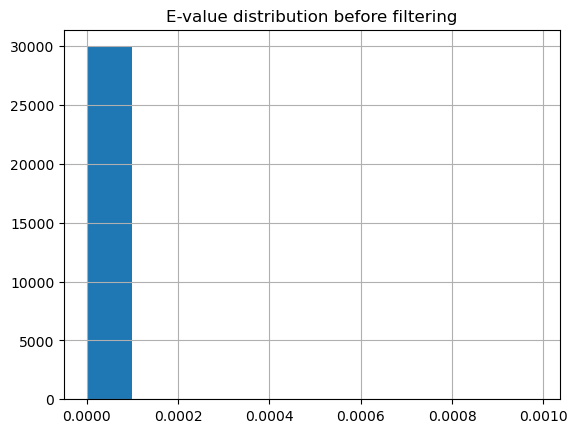

In [16]:
diamond.hist("e-value")
plt.title("E-value distribution before filtering")

Text(0.5, 1.0, 'E-value distribution after filtering')

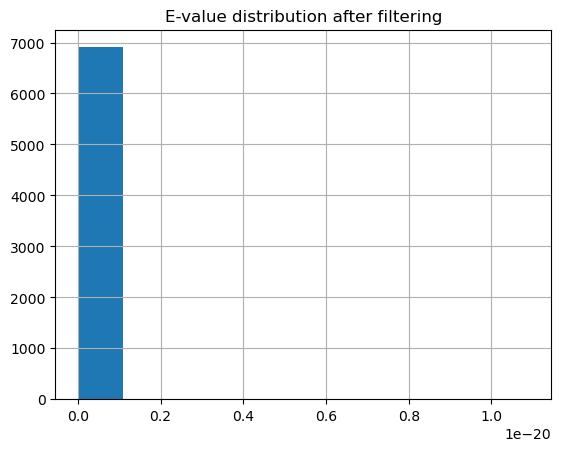

In [17]:
diamond_filtered.hist("e-value")
plt.title("E-value distribution after filtering")

Text(0.5, 1.0, 'Number of hits per contig before preprocessing')

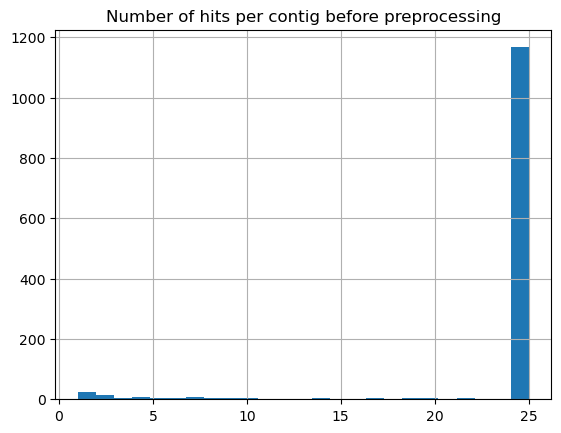

In [18]:
diamond.pivot_table(columns=['Query_id'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig before preprocessing")


Text(0.5, 1.0, 'Number of hits per contig after preprocessing')

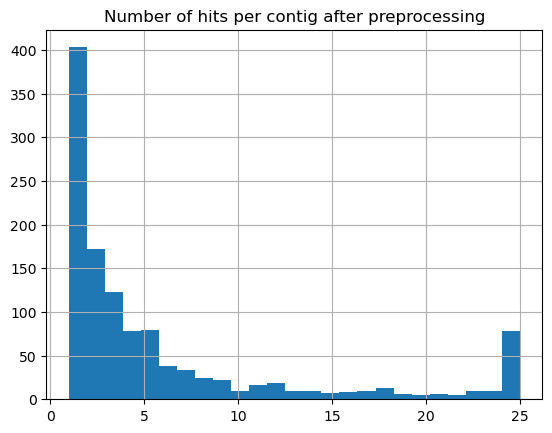

In [19]:
diamond_filtered.pivot_table(columns=['Query_id'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig after preprocessing")

#####  Inspect % identity and aligment length

Text(0.5, 1.0, 'Alignment length distribution before preprocessing')

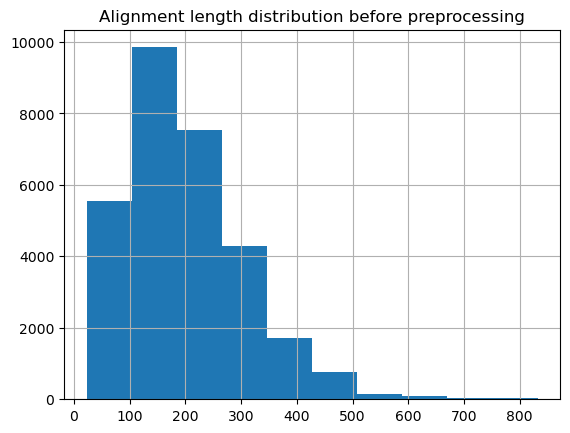

In [20]:
diamond.hist("alignment_length")
plt.title("Alignment length distribution before preprocessing")


Text(0.5, 1.0, 'Alignment length distribution after preprocessing')

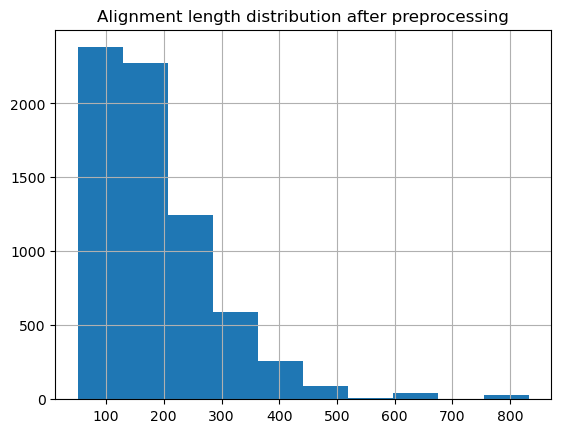

In [21]:
diamond_filtered.hist("alignment_length")
plt.title("Alignment length distribution after preprocessing")

Text(0, 0.5, 'Mistmatches')

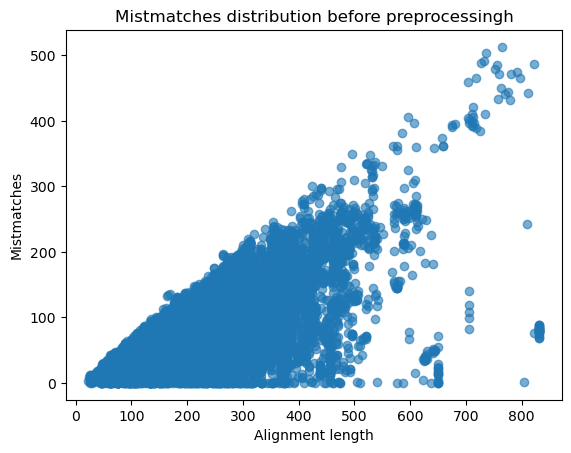

In [22]:
plt.scatter(diamond.alignment_length,diamond.mismatches,alpha=0.6)
plt.title('Mistmatches distribution before preprocessingh')
plt.xlabel('Alignment length')
plt.ylabel('Mistmatches')

Text(0, 0.5, 'Mistmatches')

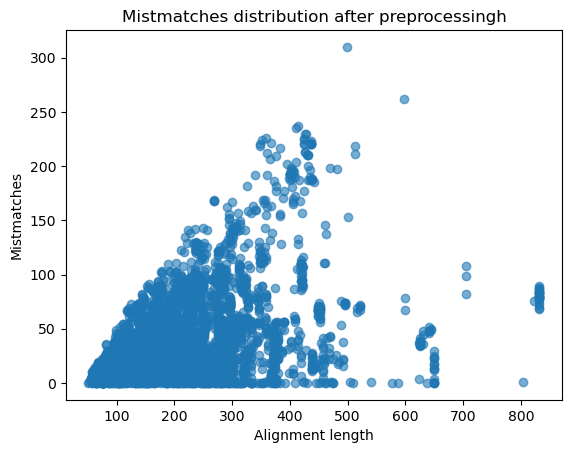

In [23]:
plt.scatter(diamond_filtered.alignment_length,diamond_filtered.mismatches,alpha=0.6)
plt.title('Mistmatches distribution after preprocessingh')
plt.xlabel('Alignment length')
plt.ylabel('Mistmatches')

Text(0.5, 1.0, 'Percentage of identity distribution before preprocessing')

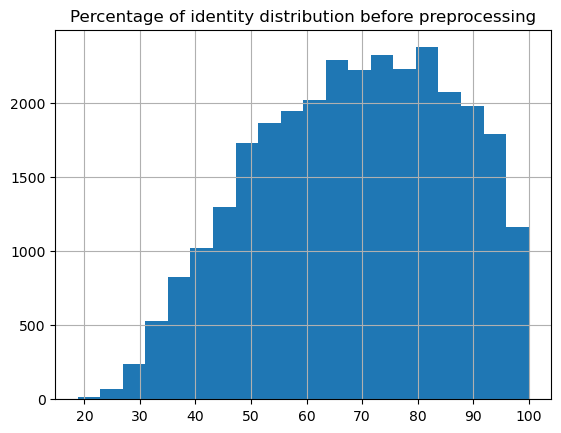

In [24]:
diamond.hist("%_identity", bins = 20)
plt.title("Percentage of identity distribution before preprocessing")


Text(0.5, 1.0, 'Percentage of identity distribution after preprocessing')

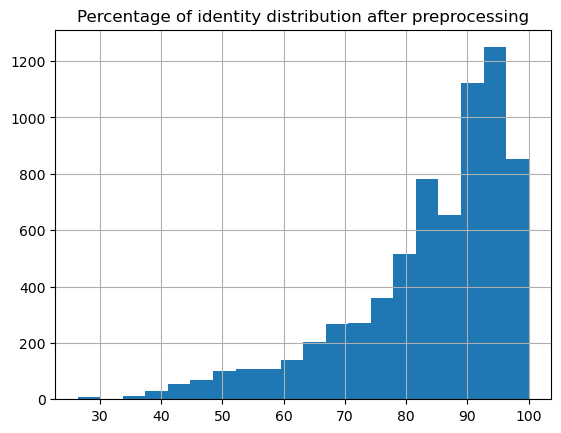

In [25]:
diamond_filtered.hist("%_identity", bins = 20)
plt.title("Percentage of identity distribution after preprocessing")

##### Link information form diamond matches and count table

In [26]:
map_table = diamond_filtered.set_index('Query_id')[["Subject_id", "e-value", "score"]]
map_table

,Subject_id,e-value,score
Query_id,,,
TRINITY_DN1457771_c0_g1_i1,NZ_CP011341_1_4810__RS_GCF_000982715_1,8.680000e-71,232.0
TRINITY_DN1457771_c0_g1_i1,PMOY01000055_1_1__GB_GCA_003165655_1,4.110000e-70,236.0
TRINITY_DN1457771_c0_g1_i1,NZ_BCXE01000002_1_11__RS_GCF_001894945_1,1.900000e-68,232.0
TRINITY_DN1457771_c0_g1_i1,PLIQ01000490_1_2__GB_GCA_003140115_1,2.370000e-68,229.0
TRINITY_DN1457771_c0_g1_i1,PLWW01000083_1_79__GB_GCA_003153125_1,6.680000e-68,230.0
...,...,...,...
TRINITY_DN130064_c4_g4_i1,NZ_SMLL01000010_1_46__RS_GCF_004681965_1,4.710000e-37,134.0
TRINITY_DN130064_c4_g4_i1,PTEU01000002_1_622__GB_GCA_004359425_1,4.710000e-37,134.0
TRINITY_DN130064_c4_g4_i1,SAIV01000082_1_50__GB_GCA_004028785_1,4.710000e-37,134.0


Now, we will merge both files by their column in common (ContigID and Subject id).

In [27]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(
  ).rename(columns={'index':'ContigID'}).set_index('Subject_id')
df


,Query_id,e-value,score,t1,t10,t11,t12,t13,t14,t15,...,t22,t23,t24,t3,t4,t5,t6,t7,t8,t9
Subject_id,,,,,,,,,,,,,,,,,,,,,
NZ_PIZU01000016_1_91__RS_GCF_002838065_1,TRINITY_DN104404_c0_g2_i3,3.290000e-80,248.0,4,2,0,0,0,3,6,...,3,1,0,2,0,2,1,2,2,7
NC_018027_1_188__RS_GCF_000266905_1,TRINITY_DN104404_c0_g2_i3,1.650000e-75,236.0,4,2,0,0,0,3,6,...,3,1,0,2,0,2,1,2,2,7
NZ_QMEW01000001_1_207__RS_GCF_003284965_1,TRINITY_DN104404_c0_g2_i3,2.160000e-75,237.0,4,2,0,0,0,3,6,...,3,1,0,2,0,2,1,2,2,7
NZ_PIZU01000016_1_91__RS_GCF_002838065_1,TRINITY_DN104404_c0_g2_i4,2.170000e-78,243.0,2,0,2,0,1,2,5,...,1,2,0,0,2,2,2,2,2,6
NC_018027_1_188__RS_GCF_000266905_1,TRINITY_DN104404_c0_g2_i4,2.180000e-73,231.0,2,0,2,0,1,2,5,...,1,2,0,0,2,2,2,2,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VAXG01000113_1_16__GB_GCA_005883355_1,TRINITY_DN191283_c1_g1_i1,4.980000e-75,236.0,1,2,2,0,2,1,1,...,5,1,0,2,0,1,0,5,2,4
VAWW01000046_1_62__GB_GCA_005884575_1,TRINITY_DN191283_c1_g1_i1,9.710000e-75,235.0,1,2,2,0,2,1,1,...,5,1,0,2,0,1,0,5,2,4
VAXT01000128_1_7__GB_GCA_005883245_1,TRINITY_DN191283_c1_g1_i1,4.920000e-74,233.0,1,2,2,0,2,1,1,...,5,1,0,2,0,1,0,5,2,4


##### Annotating the OTU
Now, we have to annotate the previous table. 

We will use the SQLite file of AnnoTree. You can safely ignore this next chunk if you are still getting familiar with SQL. 

We are annotating only with the NCBI tax id and the KEGG and Interpro Identifier.

In [28]:
conn = sqlite3.connect(mapping_db)
VALID_COLUMNS = ('Accession', 'Taxonomy', 'GTDB', 'EGGNOG', 'INTERPRO2GO','SEED', 'EC', 'KEGG', 'PFAM', 'TIGRFAM')
MapColumn = Enum('MapColumn', [(a, a) for a in VALID_COLUMNS], type=str)

def create_temp_table(conn, accessions):
    with closing(conn.cursor()) as cursor:
        cursor.execute('CREATE TEMP TABLE temp_accessions (accession TEXT)')
        cursor.executemany('INSERT INTO temp_accessions (accession) VALUES (?)', [(acc,) for acc in accessions])

def annotate_acc(conn, accessions):
    create_temp_table(conn, accessions)
    columns = [MapColumn.Taxonomy, MapColumn.INTERPRO2GO, MapColumn.KEGG]
    with closing(conn.cursor()) as cursor:
        selected = ", ".join(x.value for x in columns)
        query = f"SELECT {selected}, mappings.Accession FROM mappings " \
                f"INNER JOIN temp_accessions ON mappings.Accession = temp_accessions.accession"
        cursor.execute(query)
        res = pd.DataFrame(cursor.fetchall(), columns=[x.value for x in columns] + ['Accession']).drop_duplicates(subset=['Accession'])
        res['KEGG'] = res['KEGG'].apply(lambda val: f"K{str(int(val)).zfill(5)}" if not pd.isna(val) else "")
        res['INTERPRO2GO'] = res['INTERPRO2GO'].apply(lambda val: f"IPR{str(int(val)).zfill(6)}"  if not pd.isna(val) else "")
    return res

In [29]:
ann_sql = annotate_acc(conn, set(df.index))
conn.close()
ann_sql

,Taxonomy,INTERPRO2GO,KEGG,Accession
0,1206458,,K03497,NZ_DF850488_1_638__RS_GCF_000813185_1
1,2565556,IPR023031,K00762,NZ_CP039250_1_1586__RS_GCF_004795895_1
2,2023149,,K02863,NZ_NPFY01000020_1_44__RS_GCF_002259415_1
3,722472,,,NZ_LLYB01000127_1_102__RS_GCF_001440475_1
4,1803481,,K03798,MNJC01000100_1_8__GB_GCA_001920085_1
...,...,...,...,...
6502,2026763,,K01409,PMLB01000435_1_39__GB_GCA_003158735_1
6503,1193182,,K00215,NZ_HG764815_1_2377__RS_GCF_001050535_1
6504,47865,,,NZ_LT607754_1_1454__RS_GCF_900090285_1
6505,212767,,,NC_019966_1_2233__RS_GCF_000328565_1


Now we add new columns:

In [30]:
df = df.merge(ann_sql, left_on='Subject_id', right_on='Accession').rename(columns={"Taxonomy": "NCBI_TaxID", "Accession": "Subject_id"})
# Set column order
column_order = ['Query_id', 'Subject_id'] + [col for col in df.columns if col not in ['Query_id', 'Subject_id']]
df = df[column_order].set_index('Subject_id')
df

,Query_id,e-value,score,t1,t10,t11,t12,t13,t14,t15,...,t3,t4,t5,t6,t7,t8,t9,NCBI_TaxID,INTERPRO2GO,KEGG
Subject_id,,,,,,,,,,,,,,,,,,,,,
NZ_PIZU01000016_1_91__RS_GCF_002838065_1,TRINITY_DN104404_c0_g2_i3,3.290000e-80,248.0,4,2,0,0,0,3,6,...,2,0,2,1,2,2,7,1867256,,
NZ_PIZU01000016_1_91__RS_GCF_002838065_1,TRINITY_DN104404_c0_g2_i4,2.170000e-78,243.0,2,0,2,0,1,2,5,...,0,2,2,2,2,2,6,1867256,,
NC_018027_1_188__RS_GCF_000266905_1,TRINITY_DN104404_c0_g2_i3,1.650000e-75,236.0,4,2,0,0,0,3,6,...,2,0,2,1,2,2,7,710421,,
NC_018027_1_188__RS_GCF_000266905_1,TRINITY_DN104404_c0_g2_i4,2.180000e-73,231.0,2,0,2,0,1,2,5,...,0,2,2,2,2,2,6,710421,,
NZ_QMEW01000001_1_207__RS_GCF_003284965_1,TRINITY_DN104404_c0_g2_i3,2.160000e-75,237.0,4,2,0,0,0,3,6,...,2,0,2,1,2,2,7,2267251,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VAXG01000113_1_16__GB_GCA_005883355_1,TRINITY_DN191283_c1_g1_i1,4.980000e-75,236.0,1,2,2,0,2,1,1,...,2,0,1,0,5,2,4,1883427,,K00099
VAWW01000046_1_62__GB_GCA_005884575_1,TRINITY_DN191283_c1_g1_i1,9.710000e-75,235.0,1,2,2,0,2,1,1,...,2,0,1,0,5,2,4,1883427,,K00099
VAXT01000128_1_7__GB_GCA_005883245_1,TRINITY_DN191283_c1_g1_i1,4.920000e-74,233.0,1,2,2,0,2,1,1,...,2,0,1,0,5,2,4,1883427,,K00099


# Naive lowest common ancestor

Most AnnoTree entries have a NCBI taxonomy identifier (except those with NCBI_TaxID == 0).

You can search the corresponding taxa using NCBI. For example, let's check the first five more abundant OTU:

In [31]:
count_cols = df.select_dtypes(include=int).columns.difference(["NCBI_TaxID", "e-value", "score"])
df['Total'] = df[count_cols].sum(axis=1)
for tax in df[['Total', 'NCBI_TaxID']].groupby('NCBI_TaxID').sum().sort_values('Total', ascending=False).index[:5]:
    print(f"https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id={tax}")
df = df.drop(columns=['Total'])

https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=1883427
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=1703341
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=1945509
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=47854
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=2570352


Let's apply the LCA algorithm to one entry of the table:

In [32]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
example = df['Query_id'].iloc[10]
tax_ids_example = df[df['Query_id'] == example].NCBI_TaxID.tolist()
tree_example= ncbi.get_topology(tax_ids_example)
print(tree_example.get_ascii(attributes=["sci_name", "rank"]))
print(f"Assigned taxid: {tree_example.get_tree_root().name}")


                                                   /-Limnobacter sp. SAORIC-690, species
                                                  |
                  /unclassified Limnobacter, no rank-Limnobacter sp. CACIAM 66H1, species
                 |                                |
                 |                                 \-Limnobacter sp. MED105, species
-Limnobacter, genus
                 |--Limnobacter thiooxidans, species
                 |
                  \-Limnobacter alexandrii, species
Assigned taxid: 131079


Now, we can apply it to the whole table:

In [33]:
# This is not efficient at all, but it works
def lowest_common_ancestor(tax_ids: [int])-> int:
  """Get lowest common ancestor of a list of tax ids
  First, we test for two Micromonospora. Then, two far away species (2 is Bacteria). Finally, the invariant case
  >>> lowest_common_ancestor([946078, 307120])
  '1873'
  >>> lowest_common_ancestor([1909295, 1923970])
  '2'
  >>> lowest_common_ancestor([10, 10])
  '10'
  >>> lowest_common_ancestor([10])
  '10'
  """
  # Remove zero elements
  tax_ids = [t for t in tax_ids if t != 0]
  if len(tax_ids) == 0:
    return "0"
  if len(tax_ids) == 1:
    return str(tax_ids[0])
  try:
    tree = ncbi.get_topology(tax_ids)
    root = tree.get_tree_root()
    return root.name
  except ValueError:
    # If error, try again without the last element, which is "worse" than the previous one
    return lowest_common_ancestor(tax_ids[:-1])

import doctest
doctest.testmod()

TestResults(failed=0, attempted=4)

In [38]:
df = df.sort_values(by=["e-value", "score"], ascending=[True, False])
df_lca = df.groupby('Query_id')['NCBI_TaxID'].apply(lowest_common_ancestor).rename('LCA').to_frame()
df_lca

,LCA
Query_id,
TRINITY_DN104404_c0_g2_i3,1762
TRINITY_DN104404_c0_g2_i4,1762
TRINITY_DN104439_c0_g1_i2,131079
TRINITY_DN104439_c0_g1_i3,131079
TRINITY_DN104456_c1_g3_i2,41294
...,...
TRINITY_DN191247_c3_g2_i1,1873
TRINITY_DN191247_c4_g1_i1,1760
TRINITY_DN191255_c0_g1_i1,374


Finally, we are going to add different taxonomic ranks. First, we define a few functions. 

In [39]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()

def get_lineage(taxid):
    """Get dictionary with rank as keys and name as values
    >>> get_lineage(49992).get('species')
    'Thymus vulgaris'
    >>> get_lineage(2)
    {'no rank': 'cellular organisms', 'superkingdom': 'Bacteria'}
    >>> get_lineage(0)
    {}
    """
    if taxid <= 0:
        return {}
    try:
        lineage = ncbi.get_lineage(taxid)
        ranks = ncbi.get_rank(lineage)
        names = ncbi.translate_to_names(lineage)
        return {ranks[k]: elm for k, elm  in zip(lineage, names)}
    except ValueError:
        return {}
def get_taxonomy_row(taxid):
    """
    Parse taxa into greengenes-like format
    >>> get_taxonomy_row(49992)
    'd__Eukaryota;p__Streptophyta;c__Magnoliopsida;o__Lamiales;f__Lamiaceae;g__Thymus;s__Thymus vulgaris'
    """
    lineage = get_lineage(taxid)
    ranks = {
        'superkingdom': 'd__', 'phylum':'p__', 'class': 'c__',
        'order':'o__', 'family':'f__', 'genus':'g__', 'species':'s__'
        }
    for rank in ranks:
        ranks[rank] += lineage.get(rank, '')
    return ";".join(ranks.values())

def get_taxonomy_row2(taxid):
    """
    Parse taxa separated with semicolon
    >>> get_taxonomy_row2(49992)
    'Eukaryota;Streptophyta;Magnoliopsida;Lamiales;Lamiaceae;Thymus;Thymus vulgaris'
    """
    lineage = get_lineage(taxid)
    ranks = {rank:'' for rank in (
        'superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'
    )}        
    for rank in ranks:
        ranks[rank] += lineage.get(rank, 'X')
    return ";".join(ranks.values())
import doctest
doctest.testmod()

TestResults(failed=0, attempted=9)

In [40]:
df_lca['Taxonomy'] = [get_taxonomy_row(int(taxid)) for taxid in df_lca['LCA']]
df_lca

/software/TotalRNA-Snakemake/89cbe23f4dec0156353f15932b6e07ab_/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2033727 was translated into 2666256
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


,LCA,Taxonomy
Query_id,,
TRINITY_DN104404_c0_g2_i3,1762,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
TRINITY_DN104404_c0_g2_i4,1762,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
TRINITY_DN104439_c0_g1_i2,131079,d__Bacteria;p__Pseudomonadota;c__Betaproteobac...
TRINITY_DN104439_c0_g1_i3,131079,d__Bacteria;p__Pseudomonadota;c__Betaproteobac...
TRINITY_DN104456_c1_g3_i2,41294,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
...,...,...
TRINITY_DN191247_c3_g2_i1,1873,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
TRINITY_DN191247_c4_g1_i1,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
TRINITY_DN191255_c0_g1_i1,374,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...


In [41]:
df = df.merge(df_lca, left_on='Query_id', right_index=True)
df

,Query_id,e-value,score,t1,t10,t11,t12,t13,t14,t15,...,t5,t6,t7,t8,t9,NCBI_TaxID,INTERPRO2GO,KEGG,LCA,Taxonomy
Subject_id,,,,,,,,,,,,,,,,,,,,,
NZ_LYWY01000006_1_310__RS_GCF_001661915_1,TRINITY_DN1409962_c0_g1_i1,0.000000e+00,1538.0,1,9,0,8,2,5,23,...,1,10,13,8,7,1703341,,K07347,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
NC_007722_1_789__RS_GCF_000013005_1,TRINITY_DN1428572_c0_g1_i1,0.000000e+00,1501.0,1,9,4,2,2,6,19,...,3,3,18,2,4,314225,IPR002200,,28211,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
NZ_LRSE01000011_1_35__RS_GCF_001634625_1,TRINITY_DN1428572_c0_g1_i1,0.000000e+00,1498.0,1,9,4,2,2,6,19,...,3,3,18,2,4,1783232,,,28211,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
NZ_LNBY01000018_1_286__RS_GCF_001542855_1,TRINITY_DN1428572_c0_g1_i1,0.000000e+00,1488.0,1,9,4,2,2,6,19,...,3,3,18,2,4,499656,,,28211,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
NZ_QXFK01000009_1_88__RS_GCF_003581645_1,TRINITY_DN1428572_c0_g1_i1,0.000000e+00,1487.0,1,9,4,2,2,6,19,...,3,3,18,2,4,2306995,,,28211,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NBNH01000073_1_2__GB_GCA_004379115_1,TRINITY_DN1413830_c0_g1_i1,1.090000e-20,101.0,3,2,0,0,3,5,17,...,3,2,1,5,3,1962179,,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
QAKL01000101_1_4__GB_GCA_003343815_1,TRINITY_DN1406135_c0_g1_i1,2.070000e-22,104.0,0,0,2,0,7,4,12,...,0,0,0,0,4,1898207,,,1898207,d__Bacteria;p__Bacillota;c__Clostridia;o__Euba...
NZ_AVPI01000012_1_28__RS_GCF_000768675_1,TRINITY_DN1416588_c0_g1_i1,1.360000e-21,104.0,4,2,0,0,2,0,3,...,6,0,1,2,7,1385518,,,1385518,d__Bacteria;p__Actinomycetota;c__Actinomycetes...


### Functional annotation

Now, we are going to annotate the OTU with the KEGG and Interpro identifiers. Let's check how many non-annotated entries do we have before filtering:

In [42]:
print(f"There are {df.shape[0]} rows in the dataframe")
print(f"There are {(df['KEGG'] == '').sum()} rows with no KEGG identifier")
print(f"There are {(df['INTERPRO2GO'] == '').sum()} rows with no INTERPRO2GO identifier")

There are 6914 rows in the dataframe
There are 1854 rows with no KEGG identifier
There are 6154 rows with no INTERPRO2GO identifier


Now, we are going to kept only the best hit for each OTU.

In [44]:
df = df.sort_values(by=["e-value", "score"], ascending=[True, False]).drop_duplicates("Query_id", keep="first")
df.drop(columns=['e-value', 'score'], inplace=True)
df

,Query_id,t1,t10,t11,t12,t13,t14,t15,t16,t17,...,t5,t6,t7,t8,t9,NCBI_TaxID,INTERPRO2GO,KEGG,LCA,Taxonomy
Subject_id,,,,,,,,,,,,,,,,,,,,,
NZ_LYWY01000006_1_310__RS_GCF_001661915_1,TRINITY_DN1409962_c0_g1_i1,1,9,0,8,2,5,23,5,2,...,1,10,13,8,7,1703341,,K07347,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
NC_007722_1_789__RS_GCF_000013005_1,TRINITY_DN1428572_c0_g1_i1,1,9,4,2,2,6,19,3,2,...,3,3,18,2,4,314225,IPR002200,,28211,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
NZ_LYWY01000033_1_67__RS_GCF_001661915_1,TRINITY_DN1407825_c0_g1_i1,7,19,3,1,9,8,29,5,3,...,8,19,29,15,10,1703341,,,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
NZ_LWFF01000070_1_6__RS_GCF_001635685_1,TRINITY_DN1420129_c0_g1_i1,12,12,2,5,14,13,41,12,4,...,15,38,17,10,12,1822240,,K07243,204457,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
NZ_SWKN01000008_1_372__RS_GCF_005871185_1,TRINITY_DN1452435_c0_g1_i1,2,8,4,53,4,6,5,2,0,...,0,0,4,12,9,2570352,,,131079,d__Bacteria;p__Pseudomonadota;c__Betaproteobac...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NZ_QOIM01000026_1_170__RS_GCF_003323735_1,TRINITY_DN1413830_c0_g1_i1,3,2,0,0,3,5,17,1,5,...,3,2,1,5,3,2250578,,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
QAKL01000101_1_4__GB_GCA_003343815_1,TRINITY_DN1406135_c0_g1_i1,0,0,2,0,7,4,12,0,12,...,0,0,0,0,4,1898207,,,1898207,d__Bacteria;p__Bacillota;c__Clostridia;o__Euba...
NZ_AVPI01000012_1_28__RS_GCF_000768675_1,TRINITY_DN1416588_c0_g1_i1,4,2,0,0,2,0,3,0,2,...,6,0,1,2,7,1385518,,,1385518,d__Bacteria;p__Actinomycetota;c__Actinomycetes...


##### Adding BRITE high-level annotations
Now, we can use KEGG BRITE to add high-level annotations to this table. It's not pretty code, but it works:



In [45]:
import json
with open(brite_json, 'r') as json_file:
    # Read the contents of the file
    json_data = json_file.read()
    # Parse the JSON data
    brite = json.loads(json_data)
def get_brite(kos, include = [], ):
    annotations = dict()
    for LevelA in brite['children']:
            if LevelA['name'] not in include:
                continue
            for LevelB in LevelA.get('children', []):
                for LevelC in LevelB.get('children', []):
                    for LevelD in LevelC.get('children', []):
                        name = LevelD['name'].split()[0]
                        if name in kos:
                            description = LevelD['name'].split(';')[1].strip()
                            new_annotation = (LevelA['name'], LevelB['name'], LevelC['name'], description)
                            if name in annotations:
                                annotations[name].append(new_annotation)
                            annotations[name] = [new_annotation]
    return annotations

Now, we get some annotations. We have to decide which annotations to use. Those are the ones available in the BRITE hierarchy:

In [46]:
[y['name'] for y in brite['children']]

['09100 Metabolism',
 '09120 Genetic Information Processing',
 '09130 Environmental Information Processing',
 '09140 Cellular Processes',
 '09150 Organismal Systems',
 '09160 Human Diseases',
 '09180 Brite Hierarchies',
 '09190 Not Included in Pathway or Brite']

We are going to use annotate with both Brite and Metabolism.

### Adding Brite hierarchy

In [47]:
annotations = get_brite(df.KEGG.to_list(), include = '09180 Brite Hierarchies') 

And we add them to the DataFrame

In [48]:
df['Brite_Level1'] = [",".join(x[1] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Brite_Level2'] = [",".join(x[2] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Brite_Level3'] = [",".join(x[3] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df

,Query_id,t1,t10,t11,t12,t13,t14,t15,t16,t17,...,t8,t9,NCBI_TaxID,INTERPRO2GO,KEGG,LCA,Taxonomy,Brite_Level1,Brite_Level2,Brite_Level3
Subject_id,,,,,,,,,,,,,,,,,,,,,
NZ_LYWY01000006_1_310__RS_GCF_001661915_1,TRINITY_DN1409962_c0_g1_i1,1,9,0,8,2,5,23,5,2,...,8,7,1703341,,K07347,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09183 Protein families: signaling and cellular...,02035 Bacterial motility proteins [BR:ko02035],outer membrane usher protein
NC_007722_1_789__RS_GCF_000013005_1,TRINITY_DN1428572_c0_g1_i1,1,9,4,2,2,6,19,3,2,...,2,4,314225,IPR002200,,28211,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,
NZ_LYWY01000033_1_67__RS_GCF_001661915_1,TRINITY_DN1407825_c0_g1_i1,7,19,3,1,9,8,29,5,3,...,15,10,1703341,,,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,
NZ_LWFF01000070_1_6__RS_GCF_001635685_1,TRINITY_DN1420129_c0_g1_i1,12,12,2,5,14,13,41,12,4,...,10,12,1822240,,K07243,204457,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09183 Protein families: signaling and cellular...,02000 Transporters [BR:ko02000],high-affinity iron transporter
NZ_SWKN01000008_1_372__RS_GCF_005871185_1,TRINITY_DN1452435_c0_g1_i1,2,8,4,53,4,6,5,2,0,...,12,9,2570352,,,131079,d__Bacteria;p__Pseudomonadota;c__Betaproteobac...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NZ_QOIM01000026_1_170__RS_GCF_003323735_1,TRINITY_DN1413830_c0_g1_i1,3,2,0,0,3,5,17,1,5,...,5,3,2250578,,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
QAKL01000101_1_4__GB_GCA_003343815_1,TRINITY_DN1406135_c0_g1_i1,0,0,2,0,7,4,12,0,12,...,0,4,1898207,,,1898207,d__Bacteria;p__Bacillota;c__Clostridia;o__Euba...,,,
NZ_AVPI01000012_1_28__RS_GCF_000768675_1,TRINITY_DN1416588_c0_g1_i1,4,2,0,0,2,0,3,0,2,...,2,7,1385518,,,1385518,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,


Let's show a few annotated rows: 

In [49]:
df[df['Brite_Level1'] != '']

,Query_id,t1,t10,t11,t12,t13,t14,t15,t16,t17,...,t8,t9,NCBI_TaxID,INTERPRO2GO,KEGG,LCA,Taxonomy,Brite_Level1,Brite_Level2,Brite_Level3
Subject_id,,,,,,,,,,,,,,,,,,,,,
NZ_LYWY01000006_1_310__RS_GCF_001661915_1,TRINITY_DN1409962_c0_g1_i1,1,9,0,8,2,5,23,5,2,...,8,7,1703341,,K07347,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09183 Protein families: signaling and cellular...,02035 Bacterial motility proteins [BR:ko02035],outer membrane usher protein
NZ_LWFF01000070_1_6__RS_GCF_001635685_1,TRINITY_DN1420129_c0_g1_i1,12,12,2,5,14,13,41,12,4,...,10,12,1822240,,K07243,204457,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09183 Protein families: signaling and cellular...,02000 Transporters [BR:ko02000],high-affinity iron transporter
NZ_RAPF01000005_1_214__RS_GCF_003610805_1,TRINITY_DN1437668_c0_g1_i1,2,13,2,2,3,1,11,3,0,...,1,2,2320269,,K03497,2,d__Bacteria;p__;c__;o__;f__;g__;s__,09183 Protein families: signaling and cellular...,04812 Cytoskeleton proteins [BR:ko04812],"ParB family transcriptional regulator, chromos..."
NZ_LYWY01000040_1_343__RS_GCF_001661915_1,TRINITY_DN1424146_c0_g1_i1,1,8,1,2,1,6,14,1,0,...,2,2,1703341,,K01322,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],prolyl oligopeptidase [EC:3.4.21.26]
DELZ01000001_1_278__GB_GCA_002354635_1,TRINITY_DN1422321_c0_g1_i1,0,5,2,0,0,1,8,0,2,...,3,0,1951256,,K02014,204457,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09183 Protein families: signaling and cellular...,02000 Transporters [BR:ko02000],iron complex outermembrane recepter protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QHVE01000050_1_18__GB_GCA_003223455_1,TRINITY_DN172415_c1_g4_i2,2,2,0,2,1,4,2,1,2,...,1,0,2026742,,K03086,2026742,d__Bacteria;p__Gemmatimonadota;c__;o__;f__;g__...,09182 Protein families: genetic information pr...,03021 Transcription machinery [BR:ko03021],RNA polymerase primary sigma factor
NZ_RXOL01000001_1_318__RS_GCF_004004515_1,TRINITY_DN1460274_c0_g1_i1,0,2,2,0,2,1,4,3,1,...,2,0,2217664,,K02109,2217664,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09181 Protein families: metabolism,00194 Photosynthesis proteins [BR:ko00194],F-type H+-transporting ATPase subunit b
NZ_AEWG01000153_1_38__RS_GCF_000190375_1,TRINITY_DN1470119_c0_g1_i1,2,0,0,0,4,4,2,4,0,...,4,4,987059,,K00697,28067,d__Bacteria;p__Pseudomonadota;c__Betaproteobac...,09181 Protein families: metabolism,01003 Glycosyltransferases [BR:ko01003],trehalose 6-phosphate synthase [EC:2.4.1.15 2....


In [50]:
df.index.name = 'ContigID'
df

,Query_id,t1,t10,t11,t12,t13,t14,t15,t16,t17,...,t8,t9,NCBI_TaxID,INTERPRO2GO,KEGG,LCA,Taxonomy,Brite_Level1,Brite_Level2,Brite_Level3
ContigID,,,,,,,,,,,,,,,,,,,,,
NZ_LYWY01000006_1_310__RS_GCF_001661915_1,TRINITY_DN1409962_c0_g1_i1,1,9,0,8,2,5,23,5,2,...,8,7,1703341,,K07347,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09183 Protein families: signaling and cellular...,02035 Bacterial motility proteins [BR:ko02035],outer membrane usher protein
NC_007722_1_789__RS_GCF_000013005_1,TRINITY_DN1428572_c0_g1_i1,1,9,4,2,2,6,19,3,2,...,2,4,314225,IPR002200,,28211,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,
NZ_LYWY01000033_1_67__RS_GCF_001661915_1,TRINITY_DN1407825_c0_g1_i1,7,19,3,1,9,8,29,5,3,...,15,10,1703341,,,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,
NZ_LWFF01000070_1_6__RS_GCF_001635685_1,TRINITY_DN1420129_c0_g1_i1,12,12,2,5,14,13,41,12,4,...,10,12,1822240,,K07243,204457,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09183 Protein families: signaling and cellular...,02000 Transporters [BR:ko02000],high-affinity iron transporter
NZ_SWKN01000008_1_372__RS_GCF_005871185_1,TRINITY_DN1452435_c0_g1_i1,2,8,4,53,4,6,5,2,0,...,12,9,2570352,,,131079,d__Bacteria;p__Pseudomonadota;c__Betaproteobac...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NZ_QOIM01000026_1_170__RS_GCF_003323735_1,TRINITY_DN1413830_c0_g1_i1,3,2,0,0,3,5,17,1,5,...,5,3,2250578,,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
QAKL01000101_1_4__GB_GCA_003343815_1,TRINITY_DN1406135_c0_g1_i1,0,0,2,0,7,4,12,0,12,...,0,4,1898207,,,1898207,d__Bacteria;p__Bacillota;c__Clostridia;o__Euba...,,,
NZ_AVPI01000012_1_28__RS_GCF_000768675_1,TRINITY_DN1416588_c0_g1_i1,4,2,0,0,2,0,3,0,2,...,2,7,1385518,,,1385518,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,


### Adding KEGG metabolism

In [51]:
annotations = get_brite(df.KEGG.to_list(), include = '09100 Metabolism') 

In [52]:
df['Metabolism_Level1'] = [",".join(x[1] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Metabolism_Level2'] = [",".join(x[2] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Metabolism_Level3'] = [",".join(x[3] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df

,Query_id,t1,t10,t11,t12,t13,t14,t15,t16,t17,...,INTERPRO2GO,KEGG,LCA,Taxonomy,Brite_Level1,Brite_Level2,Brite_Level3,Metabolism_Level1,Metabolism_Level2,Metabolism_Level3
ContigID,,,,,,,,,,,,,,,,,,,,,
NZ_LYWY01000006_1_310__RS_GCF_001661915_1,TRINITY_DN1409962_c0_g1_i1,1,9,0,8,2,5,23,5,2,...,,K07347,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09183 Protein families: signaling and cellular...,02035 Bacterial motility proteins [BR:ko02035],outer membrane usher protein,,,
NC_007722_1_789__RS_GCF_000013005_1,TRINITY_DN1428572_c0_g1_i1,1,9,4,2,2,6,19,3,2,...,IPR002200,,28211,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,,,,
NZ_LYWY01000033_1_67__RS_GCF_001661915_1,TRINITY_DN1407825_c0_g1_i1,7,19,3,1,9,8,29,5,3,...,,,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,,,,
NZ_LWFF01000070_1_6__RS_GCF_001635685_1,TRINITY_DN1420129_c0_g1_i1,12,12,2,5,14,13,41,12,4,...,,K07243,204457,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09183 Protein families: signaling and cellular...,02000 Transporters [BR:ko02000],high-affinity iron transporter,,,
NZ_SWKN01000008_1_372__RS_GCF_005871185_1,TRINITY_DN1452435_c0_g1_i1,2,8,4,53,4,6,5,2,0,...,,,131079,d__Bacteria;p__Pseudomonadota;c__Betaproteobac...,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NZ_QOIM01000026_1_170__RS_GCF_003323735_1,TRINITY_DN1413830_c0_g1_i1,3,2,0,0,3,5,17,1,5,...,,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,,,
QAKL01000101_1_4__GB_GCA_003343815_1,TRINITY_DN1406135_c0_g1_i1,0,0,2,0,7,4,12,0,12,...,,,1898207,d__Bacteria;p__Bacillota;c__Clostridia;o__Euba...,,,,,,
NZ_AVPI01000012_1_28__RS_GCF_000768675_1,TRINITY_DN1416588_c0_g1_i1,4,2,0,0,2,0,3,0,2,...,,,1385518,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,,,


Let's show a few annotated rows: 

In [53]:
df[df['Metabolism_Level1'] != '']

,Query_id,t1,t10,t11,t12,t13,t14,t15,t16,t17,...,INTERPRO2GO,KEGG,LCA,Taxonomy,Brite_Level1,Brite_Level2,Brite_Level3,Metabolism_Level1,Metabolism_Level2,Metabolism_Level3
ContigID,,,,,,,,,,,,,,,,,,,,,
NZ_LYWY01000039_1_163__RS_GCF_001661915_1,TRINITY_DN1412429_c0_g1_i1,1,10,0,4,1,4,11,3,1,...,,K05898,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,,09111 Xenobiotics biodegradation and metabolism,00984 Steroid degradation [PATH:ko00984],3-oxosteroid 1-dehydrogenase [EC:1.3.99.4]
NZ_LYWY01000039_1_246__RS_GCF_001661915_1,TRINITY_DN1416455_c0_g1_i1,3,12,2,2,7,6,13,12,0,...,,K01929,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,,09107 Glycan biosynthesis and metabolism,00550 Peptidoglycan biosynthesis [PATH:ko00550],UDP-N-acetylmuramoyl-tripeptide--D-alanyl-D-al...
NZ_LYWY01000019_1_94__RS_GCF_001661915_1,TRINITY_DN1409737_c0_g1_i1,0,7,2,2,1,5,4,4,4,...,,K01657,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,,09110 Biosynthesis of other secondary metabolites,00405 Phenazine biosynthesis [PATH:ko00405],anthranilate synthase component I [EC:4.1.3.27]
NZ_LYWY01000033_1_8__RS_GCF_001661915_1,TRINITY_DN1413142_c0_g1_i1,11,16,11,6,7,14,24,11,6,...,,K02224,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,,09108 Metabolism of cofactors and vitamins,00860 Porphyrin metabolism [PATH:ko00860],"cobyrinic acid a,c-diamide synthase [EC:6.3.5...."
NZ_LYWY01000039_1_246__RS_GCF_001661915_1,TRINITY_DN1403270_c0_g1_i1,2,4,0,0,4,1,6,3,2,...,,K01929,1703341,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,,,,09107 Glycan biosynthesis and metabolism,00550 Peptidoglycan biosynthesis [PATH:ko00550],UDP-N-acetylmuramoyl-tripeptide--D-alanyl-D-al...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QHWT01000049_1_166__GB_GCA_003222675_1,TRINITY_DN1477254_c0_g1_i1,2,0,0,0,0,0,0,4,6,...,,K00697,1978231,d__Bacteria;p__Acidobacteriota;c__;o__;f__;g__...,09181 Protein families: metabolism,01003 Glycosyltransferases [BR:ko01003],trehalose 6-phosphate synthase [EC:2.4.1.15 2....,09101 Carbohydrate metabolism,00500 Starch and sucrose metabolism [PATH:ko00...,trehalose 6-phosphate synthase [EC:2.4.1.15 2....
MEQT01000185_1_14__GB_GCA_001770325_1,TRINITY_DN1419725_c0_g1_i1,2,0,0,2,0,4,0,14,2,...,,K03594,1224,d__Bacteria;p__Pseudomonadota;c__;o__;f__;g__;s__,,,,09108 Metabolism of cofactors and vitamins,00860 Porphyrin metabolism [PATH:ko00860],bacterioferritin [EC:1.16.3.1]
NZ_RXOL01000001_1_318__RS_GCF_004004515_1,TRINITY_DN1460274_c0_g1_i1,0,2,2,0,2,1,4,3,1,...,,K02109,2217664,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09181 Protein families: metabolism,00194 Photosynthesis proteins [BR:ko00194],F-type H+-transporting ATPase subunit b,09102 Energy metabolism,00195 Photosynthesis [PATH:ko00195],F-type H+-transporting ATPase subunit b


In [ ]:
df.to_csv(snakemake.output.annotated, sep='\t')